In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import openml
from scipy.stats import wilcoxon
from sklearn.metrics import zero_one_loss
%matplotlib inline

sns.set_context("paper", font_scale=1.5)

In [3]:
def bin_data(y, n_bins):
    """
    Partitions the data into ordered bins based on
    the probabilities. Returns the binned indices.
    """
    edges = np.linspace(0, 1, n_bins)
    bin_idx = np.digitize(y, edges, right=True)
    binned_idx = [np.where(bin_idx == i)[0] for i in range(n_bins)]
    
    return binned_idx
    
def bin_stats(y_true, y_proba, bin_idx):
    # mean accuracy within each bin
    bin_acc = [
        np.equal(np.argmax(y_proba[idx], axis=1), y_true[idx]).mean() if len(idx) > 0 else 0
        for idx in bin_idx
    ]
    # mean confidence of prediction within each bin
    bin_conf = [
        np.mean(np.max(y_proba[idx], axis=1)) if len(idx) > 0 else 0
        for idx in bin_idx 
    ]
    
    return np.asarray(bin_acc), np.asarray(bin_conf)

def ece(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    n = len(y_true)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    bin_sizes = [len(idx) for idx in bin_idx]
    
    ece = np.sum(np.abs(bin_acc - bin_conf) * np.asarray(bin_sizes)) / n
    
    return ece

def mce(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    mce = np.max(np.abs(bin_acc - bin_conf))
    
    return mce

def brier_score_mvloss(y_true, y_proba):
    if y_true.ndim == 1:
        y_true = np.squeeze(np.eye(len(np.unique(y_true)))[y_true.reshape(-1)])
    return np.mean(
        np.mean((y_proba - y_true)**2, axis=1)
    )


def ici(y_true, y_proba):
    y_hat = y_proba.max(axis=1)
    x_loess, y_loess = loess_fast(y_hat, y_true, alpha=0.75, degree=1)
    y_loess = y_loess.clip(0, 1)
    x_loess = x_loess.clip(0, 1)
    
    return np.mean(np.abs(x_loess - y_loess))

def E_quantile(y_true, y_proba, quantile):
    y_hat = y_proba.max(axis=1)
    x_loess, y_loess = loess_fast(y_hat, y_true, alpha=0.75, degree=1)
    y_loess = y_loess.clip(0, 1)
    x_loess = x_loess.clip(0, 1)
    
    return np.quantile(np.abs(x_loess - y_loess), q=quantile)

E50 = lambda y_true, y_proba: E_quantile(y_true, y_proba, quantile=0.5)
E90 = lambda y_true, y_proba: E_quantile(y_true, y_proba, quantile=0.9)

In [6]:
clfs = ['BagDT', 'RF', 'HistRF']
color_dict = {
    'BagDT': '#e41a1c',
    'RF': '#377eb8',
    'HistRF': '#4daf4a',
}
tag = 'n_estimators=50'
results_dir = 'cc18_results/results_cv/'

In [18]:
for file in os.listdir(results_dir)[::-1]:
    with open(results_dir + file, 'rb') as f:
        results_dict = pickle.load(f)
    break

In [19]:
results_dict.keys()

dict_keys(['task', 'task_id', 'n_samples', 'n_features', 'n_classes', 'y', 'test_indices', 'n_estimators', 'cv', 'nominal_features', 'sample_sizes', 'n_features_fitted', 'HistRF_metadata', 'HistRF', 'BagDT_metadata', 'BagDT', 'RF_metadata', 'RF'])

In [20]:

scores = np.asarray([
    [zero_one_loss(rep.argmax(1), results_dict['y'][test_idx]) for rep in fold]
    for fold, test_idx in zip(results_dict['HistRF'], results_dict['test_indices'])
])

In [23]:
print(results_dict['sample_sizes'])
print(results_dict['task_id'])
print(scores)

[4839]
146820
[[0.0268595 ]
 [0.02272727]
 [0.01859504]
 [0.02066116]
 [0.03719008]
 [0.01652893]
 [0.02892562]
 [0.01446281]
 [0.01033058]
 [0.02070393]]


<AxesSubplot:xlabel='n', ylabel='01 loss'>

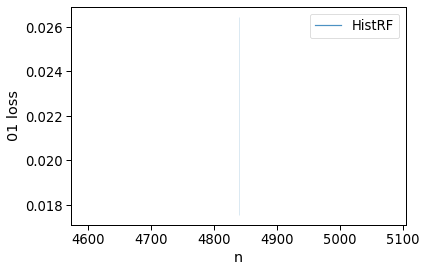

In [22]:
df = pd.DataFrame(
    scores, columns=results_dict['sample_sizes']
).melt(
    var_name='n',
    value_name='01 loss',
)
sns.lineplot(
    data=df, x='n', y='01 loss', label='HistRF', legend=True, alpha=0.8)